Data source: https://www.kaggle.com/datasets/CooperUnion/cardataset

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import warnings

import mlflow
import mlflow.sklearn

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [2]:
df = pd.read_csv("data/cardata.csv")
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

In [4]:
for column in df.columns:
    print(f"unique values in {column} column: {df[column].nunique()}")

unique values in Make column: 48
unique values in Model column: 915
unique values in Year column: 28
unique values in Engine Fuel Type column: 10
unique values in Engine HP column: 356
unique values in Engine Cylinders column: 9
unique values in Transmission Type column: 5
unique values in Driven_Wheels column: 4
unique values in Number of Doors column: 3
unique values in Market Category column: 71
unique values in Vehicle Size column: 3
unique values in Vehicle Style column: 16
unique values in highway MPG column: 59
unique values in city mpg column: 69
unique values in Popularity column: 48
unique values in MSRP column: 6049


In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')

In [6]:
string_columns = df.dtypes[df.dtypes == 'object'].index
string_columns

Index(['make', 'model', 'engine_fuel_type', 'transmission_type',
       'driven_wheels', 'market_category', 'vehicle_size', 'vehicle_style'],
      dtype='object')

In [7]:
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [8]:
for column in string_columns:
    print(f"{column}: {df[column].nunique()}")

make: 48
model: 914
engine_fuel_type: 10
transmission_type: 5
driven_wheels: 4
market_category: 71
vehicle_size: 3
vehicle_style: 16


<AxesSubplot:xlabel='msrp', ylabel='Count'>

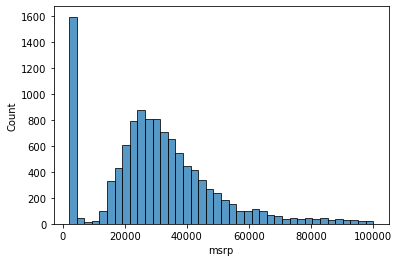

In [9]:
sns.histplot(df.msrp[df.msrp < 100000], bins=40)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

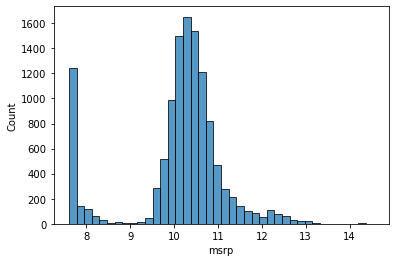

In [10]:
# df['log_msrp']
sns.histplot(np.log(df.msrp), bins=40)

# Baseline Model

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

scorer_r2 = make_scorer(r2_score)
scorer_mse = make_scorer(mean_squared_error)

In [12]:
with mlflow.start_run():
    mlflow.log_param("Experiment Name", "Baseline Model with numerical values")
    mlflow.log_param("Model", "Linear Regression")
    mlflow.log_param("log_y", 0)
    lr = LinearRegression()
    df_copy = df.dropna()
    X = df_copy.drop(columns=string_columns).drop(columns=["msrp"])
    y = df_copy.msrp.values
    output = cross_val_score(lr, X, y, cv=5, scoring=scorer_r2)
    mlflow.log_metric("r2 mean", np.mean(output))
    mlflow.log_metric("r2 std", np.std(output))
    output = cross_val_score(lr, X, y, cv=5, scoring=scorer_mse)
    mlflow.log_metric("mse mean", np.mean(output))
    mlflow.log_metric("mse std", np.std(output))

In [13]:
with mlflow.start_run():
    mlflow.log_param("Experiment Name", "Model with numerical features and log target")
    mlflow.log_param("Model", "Linear Regression")
    mlflow.log_param("log_y", 1)
    lr = LinearRegression()
    df_copy = df.dropna()
    X = df_copy.drop(columns=string_columns).drop(columns=["msrp"])
    y = np.log(df_copy.msrp.values)
    output = cross_val_score(lr, X, y, cv=5, scoring=scorer_r2)
    mlflow.log_metric("r2 mean", np.mean(output))
    mlflow.log_metric("r2 std", np.std(output))
    output = cross_val_score(lr, X, y, cv=5, scoring=scorer_mse)
    mlflow.log_metric("mse mean", np.mean(output))
    mlflow.log_metric("mse std", np.std(output))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df, np.log(df.msrp.values), test_size=0.2, random_state=101)

# Feature Engineering

In [15]:
mean_by_make = X_train.groupby(by="make").mean()["msrp"].sort_values()

top_makes = set(mean_by_make[mean_by_make >= 100000].index)
middle_makes = set(mean_by_make[mean_by_make >= 50000].index) - top_makes
low_makes = set(mean_by_make[mean_by_make >= 20000].index) - top_makes - middle_makes
ultra_low_makes = set(mean_by_make[mean_by_make < 20000].index) - top_makes - middle_makes - low_makes

In [16]:
from collections import defaultdict

make_mapping = defaultdict(lambda: 'low_make')
for make in top_makes:
    make_mapping[make] = "top_make"
for make in middle_makes:
    make_mapping[make] = "middle_make"
for make in low_makes:
    make_mapping[make] = "low_make"
for make in ultra_low_makes:
    make_mapping[make] = "ultra_low_make"

In [17]:
X_train['make'] = X_train['make'].map(make_mapping)
X_test["make"] = X_test["make"].map(make_mapping)

In [18]:
df.isna().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

In [19]:
df[df.engine_hp.isna()]

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
539,fiat,500e,2015,electric,NaN,0.0,direct_drive,front_wheel_drive,2.0,hatchback,compact,2dr_hatchback,108,122,819,31800
540,fiat,500e,2016,electric,NaN,0.0,direct_drive,front_wheel_drive,2.0,hatchback,compact,2dr_hatchback,103,121,819,31800
541,fiat,500e,2017,electric,NaN,0.0,direct_drive,front_wheel_drive,2.0,hatchback,compact,2dr_hatchback,103,121,819,31800
2905,lincoln,continental,2017,premium_unleaded_(recommended),NaN,6.0,automatic,all_wheel_drive,4.0,luxury,large,sedan,25,17,61,55915
2906,lincoln,continental,2017,premium_unleaded_(recommended),NaN,6.0,automatic,front_wheel_drive,4.0,luxury,large,sedan,27,18,61,62915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9850,kia,soul_ev,2015,electric,NaN,0.0,direct_drive,front_wheel_drive,4.0,NaN,compact,wagon,92,120,1720,35700
9851,kia,soul_ev,2015,electric,NaN,0.0,direct_drive,front_wheel_drive,4.0,NaN,compact,wagon,92,120,1720,33700
9852,kia,soul_ev,2016,electric,NaN,0.0,direct_drive,front_wheel_drive,4.0,NaN,compact,wagon,92,120,1720,33950
9853,kia,soul_ev,2016,electric,NaN,0.0,direct_drive,front_wheel_drive,4.0,NaN,compact,wagon,92,120,1720,31950


In [20]:
df[df.engine_hp.isna()]["make"].value_counts()

tesla            18
ford             13
nissan           10
lincoln           8
chevrolet         6
kia               5
fiat              3
honda             2
toyota            2
mitsubishi        1
mercedes-benz     1
Name: make, dtype: int64

In [21]:
df[df.engine_hp.isna()]["vehicle_size"].value_counts()

compact    28
large      28
midsize    13
Name: vehicle_size, dtype: int64

In [22]:
df[df.engine_hp.isna()].engine_fuel_type.value_counts()

electric                            44
regular_unleaded                    14
flex-fuel_(unleaded/natural_gas)     6
premium_unleaded_(recommended)       4
diesel                               1
Name: engine_fuel_type, dtype: int64

In [23]:
hp_by_size = X_train.groupby("vehicle_size").mean()["engine_hp"].to_dict()
hp_by_size

{'compact': 205.89847848898216,
 'large': 317.4677565849228,
 'midsize': 254.7603353570396}

In [24]:
def fill_engine_hp(row):
    if pd.isna(row[1]):
        return hp_by_size[row[0]]
    return row[1]
X_train["engine_hp"] = X_train[["vehicle_size", "engine_hp"]].apply(fill_engine_hp, axis=1)
X_test["engine_hp"] = X_test[["vehicle_size", "engine_hp"]].apply(fill_engine_hp, axis=1)

In [25]:
df[df["engine_fuel_type"].isna()]

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
11321,suzuki,verona,2004,NaN,155.0,6.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,25,17,481,17199
11322,suzuki,verona,2004,NaN,155.0,6.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,25,17,481,20199
11323,suzuki,verona,2004,NaN,155.0,6.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,25,17,481,18499


In [26]:
df.engine_fuel_type.value_counts()

regular_unleaded                                7172
premium_unleaded_(required)                     2009
premium_unleaded_(recommended)                  1523
flex-fuel_(unleaded/e85)                         899
diesel                                           154
electric                                          66
flex-fuel_(premium_unleaded_required/e85)         54
flex-fuel_(premium_unleaded_recommended/e85)      26
flex-fuel_(unleaded/natural_gas)                   6
natural_gas                                        2
Name: engine_fuel_type, dtype: int64

In [27]:
X_train["engine_fuel_type"].fillna("regular_unleaded", inplace=True)
X_test["engine_fuel_type"].fillna("regular_unleaded", inplace=True)

In [28]:
def combine_engine_fuel_type(row):
    if "(" in row:
        return row.split("(")[0]
    if row == "natural_gas":
        return "regular_unleaded"
    return row
X_train["engine_fuel_type"] = X_train["engine_fuel_type"].apply(combine_engine_fuel_type)
X_test["engine_fuel_type"] = X_test["engine_fuel_type"].apply(combine_engine_fuel_type)

In [29]:
df[df["engine_cylinders"].isna()]

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
1983,chevrolet,bolt_ev,2017,electric,200.0,NaN,direct_drive,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,110,128,1385,40905
1984,chevrolet,bolt_ev,2017,electric,200.0,NaN,direct_drive,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,110,128,1385,36620
3716,volkswagen,e-golf,2015,electric,115.0,NaN,direct_drive,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,105,126,873,33450
3717,volkswagen,e-golf,2015,electric,115.0,NaN,direct_drive,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,105,126,873,35445
3718,volkswagen,e-golf,2016,electric,115.0,NaN,direct_drive,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,105,126,873,28995
3719,volkswagen,e-golf,2016,electric,115.0,NaN,direct_drive,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,105,126,873,35595
5778,mitsubishi,i-miev,2014,electric,NaN,NaN,direct_drive,rear_wheel_drive,4.0,hatchback,compact,4dr_hatchback,99,126,436,22995
5779,mitsubishi,i-miev,2016,electric,66.0,NaN,direct_drive,rear_wheel_drive,4.0,hatchback,compact,4dr_hatchback,99,126,436,22995
5780,mitsubishi,i-miev,2017,electric,66.0,NaN,direct_drive,rear_wheel_drive,4.0,hatchback,compact,4dr_hatchback,102,121,436,22995
8373,toyota,rav4_ev,2012,electric,154.0,NaN,direct_drive,front_wheel_drive,4.0,crossover,midsize,4dr_suv,74,78,2031,49800


In [30]:
df.engine_cylinders.value_counts(dropna=False)

4.0     4752
6.0     4489
8.0     2031
12.0     230
5.0      225
10.0      68
0.0       56
NaN       30
3.0       30
16.0       3
Name: engine_cylinders, dtype: int64

In [31]:
df[df["engine_fuel_type"] == "electric"]["engine_cylinders"].value_counts(dropna=False)

0.0    56
NaN    10
Name: engine_cylinders, dtype: int64

In [32]:
def fill_engine_cylinders(row):
    if row[0] == "electric":
        return 0.0
    elif row[1] == "rx-7":
        return 2.0
    elif row[1] == "rx-8":
        return 4.0
    return row[2]

X_train["engine_cylinders"] = X_train[["engine_fuel_type", "model", "engine_cylinders"]].apply(fill_engine_cylinders, axis=1)
X_test["engine_cylinders"] = X_test[["engine_fuel_type", "model", "engine_cylinders"]].apply(fill_engine_cylinders, axis=1)

In [33]:
df[df["number_of_doors"].isna()]

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
4666,ferrari,ff,2013,premium_unleaded_(required),651.0,12.0,automated_manual,all_wheel_drive,NaN,"exotic,high-performance",large,coupe,16,11,2774,295000
6930,tesla,model_s,2016,electric,NaN,0.0,direct_drive,all_wheel_drive,NaN,"exotic,performance",large,sedan,105,102,1391,79500
6931,tesla,model_s,2016,electric,NaN,0.0,direct_drive,all_wheel_drive,NaN,"exotic,performance",large,sedan,101,98,1391,66000
6932,tesla,model_s,2016,electric,NaN,0.0,direct_drive,all_wheel_drive,NaN,"exotic,high-performance",large,sedan,105,92,1391,134500
6933,tesla,model_s,2016,electric,NaN,0.0,direct_drive,rear_wheel_drive,NaN,"exotic,performance",large,sedan,100,97,1391,74500
6934,tesla,model_s,2016,electric,NaN,0.0,direct_drive,all_wheel_drive,NaN,"exotic,performance",large,sedan,107,101,1391,71000


In [34]:
def fill_number_of_doors(row):
    if pd.isna(row[0]):
        if row[1] == "ff":
            return 2.0
        else:
            return 4.0
    return row[0]

X_train["number_of_doors"] = X_train[["number_of_doors", "model"]].apply(fill_number_of_doors, axis=1)
X_test["number_of_doors"] = X_test[["number_of_doors", "model"]].apply(fill_number_of_doors, axis=1)

In [35]:
df["market_category"].str.split(',').explode("market_category").unique()

array(['factory_tuner', 'luxury', 'high-performance', 'performance',
       'flex_fuel', nan, 'hatchback', 'hybrid', 'diesel', 'exotic',
       'crossover'], dtype=object)

In [36]:
train_cat = X_train["market_category"].str.split(',').explode("market_category").unique()

In [37]:
test_cat = X_test["market_category"].str.split(',').explode("market_category").unique()

In [38]:
[cat for cat in test_cat if cat not in train_cat]

[nan]

In [39]:
X_train["market_category"].fillna("other", inplace=True)
X_test["market_category"].fillna("other", inplace=True)

In [40]:
from sklearn.preprocessing import MultiLabelBinarizer

In [41]:
X_train["market_category"] = X_train["market_category"].str.split(',')
X_test["market_category"] = X_test["market_category"].str.split(',')

In [42]:
mlb = MultiLabelBinarizer()
X_train = X_train.join(
    pd.DataFrame(
        mlb.fit_transform(X_train.pop("market_category")),
        columns=mlb.classes_,
        index=X_train.index
    )
)
X_test = X_test.join(
    pd.DataFrame(
        mlb.transform(X_test.pop("market_category")),
        columns=mlb.classes_,
        index=X_test.index
    )
)

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9531 entries, 10400 to 1547
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               9531 non-null   object 
 1   model              9531 non-null   object 
 2   year               9531 non-null   int64  
 3   engine_fuel_type   9531 non-null   object 
 4   engine_hp          9531 non-null   float64
 5   engine_cylinders   9531 non-null   float64
 6   transmission_type  9531 non-null   object 
 7   driven_wheels      9531 non-null   object 
 8   number_of_doors    9531 non-null   float64
 9   vehicle_size       9531 non-null   object 
 10  vehicle_style      9531 non-null   object 
 11  highway_mpg        9531 non-null   int64  
 12  city_mpg           9531 non-null   int64  
 13  popularity         9531 non-null   int64  
 14  msrp               9531 non-null   int64  
 15  crossover          9531 non-null   int32  
 16  diesel             9

In [44]:
df.model.value_counts()

silverado_1500        156
tundra                140
f-150                 126
sierra_1500            90
beetle_convertible     89
                     ... 
mkz_hybrid              1
m4_gts                  1
lfa                     1
horizon                 1
zephyr                  1
Name: model, Length: 914, dtype: int64

In [45]:
X_train.drop(columns=["model"], inplace=True)
X_test.drop(columns=["model"], inplace=True)

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9531 entries, 10400 to 1547
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               9531 non-null   object 
 1   year               9531 non-null   int64  
 2   engine_fuel_type   9531 non-null   object 
 3   engine_hp          9531 non-null   float64
 4   engine_cylinders   9531 non-null   float64
 5   transmission_type  9531 non-null   object 
 6   driven_wheels      9531 non-null   object 
 7   number_of_doors    9531 non-null   float64
 8   vehicle_size       9531 non-null   object 
 9   vehicle_style      9531 non-null   object 
 10  highway_mpg        9531 non-null   int64  
 11  city_mpg           9531 non-null   int64  
 12  popularity         9531 non-null   int64  
 13  msrp               9531 non-null   int64  
 14  crossover          9531 non-null   int32  
 15  diesel             9531 non-null   int32  
 16  exotic             9

In [47]:
X_train.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0)

In [48]:
X_train.engine_fuel_type.value_counts()

regular_unleaded     5717
premium_unleaded_    2840
flex-fuel_            786
diesel                133
electric               55
Name: engine_fuel_type, dtype: int64

In [49]:
X_test.engine_fuel_type.value_counts()

regular_unleaded     1460
premium_unleaded_     692
flex-fuel_            199
diesel                 21
electric               11
Name: engine_fuel_type, dtype: int64

In [50]:
X_train.transmission_type.value_counts()

automatic           6618
manual              2339
automated_manual     501
direct_drive          57
unknown               16
Name: transmission_type, dtype: int64

In [51]:
X_test.transmission_type.value_counts()

automatic           1648
manual               596
automated_manual     125
direct_drive          11
unknown                3
Name: transmission_type, dtype: int64

In [52]:
X_train.driven_wheels.value_counts()

front_wheel_drive    3852
rear_wheel_drive     2698
all_wheel_drive      1876
four_wheel_drive     1105
Name: driven_wheels, dtype: int64

In [53]:
X_test.driven_wheels.value_counts()

front_wheel_drive    935
rear_wheel_drive     673
all_wheel_drive      477
four_wheel_drive     298
Name: driven_wheels, dtype: int64

In [54]:
X_train.vehicle_size.value_counts()

compact    3837
midsize    3469
large      2225
Name: vehicle_size, dtype: int64

In [55]:
X_test.vehicle_size.value_counts()

compact    927
midsize    904
large      552
Name: vehicle_size, dtype: int64

In [56]:
X_train.vehicle_style.value_counts()

sedan                  2412
4dr_suv                1994
coupe                   976
convertible             637
4dr_hatchback           565
crew_cab_pickup         542
extended_cab_pickup     495
wagon                   473
2dr_hatchback           420
passenger_minivan       338
regular_cab_pickup      308
2dr_suv                 112
passenger_van           106
cargo_van                73
cargo_minivan            59
convertible_suv          21
Name: vehicle_style, dtype: int64

In [57]:
X_test.vehicle_style.value_counts()

sedan                  636
4dr_suv                494
coupe                  235
convertible            156
crew_cab_pickup        139
4dr_hatchback          137
extended_cab_pickup    128
wagon                  119
2dr_hatchback           86
regular_cab_pickup      84
passenger_minivan       79
2dr_suv                 26
passenger_van           22
cargo_van               22
cargo_minivan           12
convertible_suv          8
Name: vehicle_style, dtype: int64

In [58]:
[style for style in X_test.vehicle_style.unique() if style not in X_train.vehicle_style.unique()]

[]

In [59]:
string_columns = list(X_train.select_dtypes(include="object").columns)
print(string_columns)

['make', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 'vehicle_size', 'vehicle_style']


In [60]:
from sklearn.preprocessing import OneHotEncoder

In [61]:
ohe = OneHotEncoder()
X_train = X_train.join(
    pd.DataFrame(
        ohe.fit_transform(
            X_train[string_columns]
        ).todense(), 
        columns=ohe.get_feature_names_out(), 
        index=X_train.index
    )
).drop(
    columns=string_columns
)
X_test = X_test.join(
    pd.DataFrame(
        ohe.transform(
            X_test[string_columns]
        ).todense(),
        columns=ohe.get_feature_names_out(),
        index=X_test.index
    )
).drop(
    columns=string_columns
)

In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9531 entries, 10400 to 1547
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year                                9531 non-null   int64  
 1   engine_hp                           9531 non-null   float64
 2   engine_cylinders                    9531 non-null   float64
 3   number_of_doors                     9531 non-null   float64
 4   highway_mpg                         9531 non-null   int64  
 5   city_mpg                            9531 non-null   int64  
 6   popularity                          9531 non-null   int64  
 7   msrp                                9531 non-null   int64  
 8   crossover                           9531 non-null   int32  
 9   diesel                              9531 non-null   int32  
 10  exotic                              9531 non-null   int32  
 11  factory_tuner                       953

In [63]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2383 entries, 786 to 9455
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year                                2383 non-null   int64  
 1   engine_hp                           2383 non-null   float64
 2   engine_cylinders                    2383 non-null   float64
 3   number_of_doors                     2383 non-null   float64
 4   highway_mpg                         2383 non-null   int64  
 5   city_mpg                            2383 non-null   int64  
 6   popularity                          2383 non-null   int64  
 7   msrp                                2383 non-null   int64  
 8   crossover                           2383 non-null   int32  
 9   diesel                              2383 non-null   int32  
 10  exotic                              2383 non-null   int32  
 11  factory_tuner                       2383 

In [64]:
X_train.drop(columns=["msrp"], inplace=True)
X_test.drop(columns=["msrp"], inplace=True)

In [65]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.feature_names_in_)
X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.feature_names_in_)

In [66]:
X_train.describe()

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,crossover,diesel,exotic,...,vehicle_style_convertible,vehicle_style_convertible_suv,vehicle_style_coupe,vehicle_style_crew_cab_pickup,vehicle_style_extended_cab_pickup,vehicle_style_passenger_minivan,vehicle_style_passenger_van,vehicle_style_regular_cab_pickup,vehicle_style_sedan,vehicle_style_wagon
count,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,...,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000,9531.000000
mean,0.755099,0.205844,0.351478,0.716242,0.042881,0.098068,0.275033,0.171441,0.018676,0.042283,...,0.066835,0.002203,0.102403,0.056867,0.051936,0.035463,0.011122,0.032316,0.253069,0.049628
std,0.281487,0.115427,0.111640,0.441704,0.026584,0.070648,0.255599,0.376913,0.135385,0.201245,...,0.249748,0.046890,0.303193,0.231601,0.221909,0.184957,0.104876,0.176846,0.434793,0.217186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.629630,0.121564,0.250000,0.000000,0.029240,0.069231,0.096729,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.925926,0.181818,0.375000,1.000000,0.040936,0.084615,0.244562,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.962963,0.258985,0.375000,1.000000,0.052632,0.115385,0.354907,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model Selection

In [67]:
with mlflow.start_run():
    mlflow.log_param("Experiment Name", "Model with engineered features")
    mlflow.log_param("Model", "Linear Regression")
    mlflow.log_param("log_y", 1)
    lr = LinearRegression()
    output = cross_val_score(lr, X_train, y_train, cv=5, scoring=scorer_r2)
    mlflow.log_metric("r2 mean", np.mean(output))
    mlflow.log_metric("r2 std", np.std(output))
    output = cross_val_score(lr, X_train, y_train, cv=5, scoring=scorer_mse)
    mlflow.log_metric("mse mean", np.mean(output))
    mlflow.log_metric("mse std", np.std(output))

In [68]:
from sklearn.linear_model import Lasso

In [69]:
with mlflow.start_run():
    mlflow.log_param("Experiment Name", "Lasso Model 1")
    mlflow.log_param("Model", "Lasso Regression")
    mlflow.log_param("log_y", 1)
    lasso = Lasso()
    output = cross_val_score(lasso, X_train, y_train, cv=5, scoring=scorer_r2)
    mlflow.log_metric("r2 mean", np.mean(output))
    mlflow.log_metric("r2 std", np.std(output))
    output = cross_val_score(lasso, X_train, y_train, cv=5, scoring=scorer_mse)
    mlflow.log_metric("mse mean", np.mean(output))
    mlflow.log_metric("mse std", np.std(output))


In [70]:
from sklearn.linear_model import Ridge
with mlflow.start_run():
    mlflow.log_param("Experiment Name", "Ridge Model 1")
    mlflow.log_param("Model", "Ridge Regression")
    mlflow.log_param("log_y", 1)
    ridge = Ridge()
    output = cross_val_score(ridge, X_train, y_train, cv=5, scoring=scorer_r2)
    mlflow.log_metric("r2 mean", np.mean(output))
    mlflow.log_metric("r2 std", np.std(output))
    output = cross_val_score(ridge, X_train, y_train, cv=5, scoring=scorer_mse)
    mlflow.log_metric("mse mean", np.mean(output))
    mlflow.log_metric("mse std", np.std(output))

In [73]:
from sklearn.svm import SVR
with mlflow.start_run():
    mlflow.log_param("Experiment Name", "Support Vector Model defaults")
    mlflow.log_param("Model", "SVR")
    mlflow.log_param("log_y", 1)
    svr = SVR()
    output = cross_val_score(svr, X_train, y_train, cv=5, scoring=scorer_r2, n_jobs=-1)
    mlflow.log_metric("r2 mean", np.mean(output))
    mlflow.log_metric("r2 std", np.std(output))
    output = cross_val_score(svr, X_train, y_train, cv=5, scoring=scorer_mse)
    mlflow.log_metric("mse mean", np.mean(output))
    mlflow.log_metric("mse std", np.std(output))

In [74]:
from sklearn.ensemble import RandomForestRegressor
with mlflow.start_run():
    mlflow.log_param("Experiment Name", "Random Forest defaults")
    mlflow.log_param("Model", "Random Forest")
    mlflow.log_param("log_y", 1)
    rfr = RandomForestRegressor()
    output = cross_val_score(rfr, X_train, y_train, cv=5, scoring=scorer_r2, n_jobs=-1)
    mlflow.log_metric("r2 mean", np.mean(output))
    mlflow.log_metric("r2 std", np.std(output))
    output = cross_val_score(rfr, X_train, y_train, cv=5, scoring=scorer_mse)
    mlflow.log_metric("mse mean", np.mean(output))
    mlflow.log_metric("mse std", np.std(output))

In [91]:
mlflow.list_run_infos('0')[0].run_id

'c733a6f8a8914c9aaa1eb967b938a19e'

In [93]:
mlflow.get_run('c733a6f8a8914c9aaa1eb967b938a19e').to_dictionary()['data']

{'metrics': {'mse mean': 0.012425207154832491,
  'mse std': 0.0010935999356477793,
  'r2 mean': 0.989998101447954,
  'r2 std': 0.0012060554929634107},
 'params': {'Experiment Name': 'Random Forest defaults',
  'log_y': '1',
  'Model': 'Random Forest'},
 'tags': {'mlflow.source.name': 'C:\\Users\\Safiuddin\\anaconda3\\lib\\site-packages\\ipykernel_launcher.py',
  'mlflow.source.type': 'LOCAL',
  'mlflow.user': 'Safiuddin'}}

In [94]:
mse_mean = []
exp_name = []
r2_mean = []
for run in mlflow.list_run_infos('0'):
    data = mlflow.get_run(run.run_id).to_dictionary()["data"]
    exp_name.append(data["params"]["Experiment Name"])
    mse_mean.append(data["metrics"]["mse mean"])
    r2_mean.append(data["metrics"]["r2 mean"])

results = pd.DataFrame(
    {
        "Experiment": exp_name,
        "MSE": mse_mean,
        "R2": r2_mean
    }
)

In [95]:
results

,Experiment,MSE,R2
0,Random Forest defaults,1.242521e-02,0.989998
1,Support Vector Model defaults,9.189818e-02,0.925556
2,Ridge Model 1,1.839058e-01,0.850906
3,Lasso Model 1,1.235726e+00,-0.000465
4,Model with engineered features,1.940595e-01,0.842881
5,Model with numerical features and log target,2.446902e-01,0.724801
6,Baseline Model with numerical values,2.725255e+09,0.451119


In [96]:
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

0.9914334905972427